In [ ]:
# !pip install pandas==1.3.4
# !pip install numpy==1.21.2
# !pip install scipy==1.7.3
# !pip install matplotlib==3.5.0
# !pip install scikit-learn==1.0.1
# !pip install scikit-optimize==0.9.0

# Grid Search

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [3]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get distribution of the target variable

In [5]:
df_train['y'].value_counts(True)

0    0.882843
1    0.117157
Name: y, dtype: float64

In [6]:
df_test['y'].value_counts(True)

0    0.884564
1    0.115436
Name: y, dtype: float64

Get only numerical features from the train data

In [7]:
X_train_numerical = df_train.select_dtypes(include=np.number).drop(columns=['y'])
y_train = df_train['y']

X_train_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       40689 non-null  int64
 1   balance   40689 non-null  int64
 2   day       40689 non-null  int64
 3   duration  40689 non-null  int64
 4   campaign  40689 non-null  int64
 5   pdays     40689 non-null  int64
 6   previous  40689 non-null  int64
dtypes: int64(7)
memory usage: 2.5 MB


Get only numerical features from the test data

In [8]:
X_test_numerical = df_test.select_dtypes(include=np.number).drop(columns=['y'])
y_test = df_test['y']

X_test_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       4522 non-null   int64
 1   balance   4522 non-null   int64
 2   day       4522 non-null   int64
 3   duration  4522 non-null   int64
 4   campaign  4522 non-null   int64
 5   pdays     4522 non-null   int64
 6   previous  4522 non-null   int64
dtypes: int64(7)
memory usage: 282.6 KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [9]:
# Fit the model on train data 
model = RandomForestClassifier(random_state=0)
model.fit(X_train_numerical,y_train)

# Evaluate the model on the test data 
y_pred = model.predict(X_test_numerical)
print(f1_score(y_test, y_pred))

0.43667068757539196


Defining the Hyperparameter Space for experiment using numerical features only 

In [10]:
hyperparameter_space = { 
"n_estimators": [25,50,100,150,200], 
"criterion": ["gini", "entropy"], 
"class_weight": ["balanced","balanced_subsample"],
"min_samples_split": [0.01,0.1,0.25,0.5,0.75,1.0],
} 

Perform Grid Search on numerical features only

In [11]:
# Initiate the model
model = RandomForestClassifier(random_state=0)

# Initiate the Grid Search Class
clf = GridSearchCV(model, hyperparameter_space, 
                   scoring = 'f1', cv=5, 
                   n_jobs=-1, refit = True,
                   verbose=2)

# Run the Grid Search CV
clf.fit(X_train_numerical, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_split': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
                         'n_estimators': [25, 50, 100, 150, 200]},
             scoring='f1', verbose=2)

Get the best set of hyperparameters along with the average F1-Score from the 5-folds CV

In [12]:
clf.best_params_,clf.best_score_

({'class_weight': 'balanced',
  'criterion': 'entropy',
  'min_samples_split': 0.01,
  'n_estimators': 150},
 0.4933329227505155)

Calculate the F1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters

In [13]:
clf.score(X_test_numerical,y_test)

0.4949793266391022

Start of the experiment with all features

In [14]:
# Get list of numerical features
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

# Get list of categorical features
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [15]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [17]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [18]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [19]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [20]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Re-define the Hyperparameter Space to match the expected input of the `Pipeline` object.

In [21]:
hyperparameter_space = { 
"model__n_estimators": [25,50,100,150,200], 
"model__criterion": ["gini", "entropy"], 
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": [0.01,0.1,0.25,0.5,0.75,1.0],
} 

Perform Grid Search on all features

In [22]:
# Initiate the Grid Search Class
clf = GridSearchCV(pipe, hyperparameter_space, 
                   scoring = 'f1', cv=5, 
                   n_jobs=-1, refit = True,
                   verbose=2)

# Run the Grid Search CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous']),
                                                                        ('cat',
                                                                         OneHotEncod

Get the best set of hyperparameters along with the average F1-Score from the 5-folds CV

In [23]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__criterion': 'gini',
  'model__min_samples_split': 0.01,
  'model__n_estimators': 100},
 0.54949186142684)

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters

In [24]:
clf.score(X_test_full,y_test)

0.5497685185185185

# Random Search

In [25]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint,truncnorm
from sklearn.model_selection import RandomizedSearchCV

In [26]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [27]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [28]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [29]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [30]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [31]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [33]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [34]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [35]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [36]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Define the hyperparameter space

In [37]:
hyperparameter_space = { 
"model__n_estimators": randint(5, 200), 
"model__criterion": ["gini", "entropy"],
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": truncnorm(a=0,b=0.5,loc=0.005, scale=0.01),
} 

Perform Random Search

In [38]:
# Initiate the Random Search Class
clf = RandomizedSearchCV(pipe, hyperparameter_space, 
                         n_iter = 200, random_state = 0,
                         scoring = 'f1', cv=5, 
                         n_jobs=-1, refit = True,
                         verbose=2)

# Run the Random Search CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'balance',
                                                                                'day',
                                                                                'duration',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous']),
                                                                              ('cat',
            

Get the best set of hyperparameters along with the average F1-Score from the 5-folds CV

In [39]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__criterion': 'entropy',
  'model__min_samples_split': 0.005155815445940717,
  'model__n_estimators': 187},
 0.5624773971858765)

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters

In [40]:
clf.score(X_test_full,y_test)

0.5638872225554888

# Coarse-to-Fine Search

In [41]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import scipy
from scipy.stats import randint,truncnorm
from sklearn.base import clone
from sklearn.model_selection import ParameterSampler, cross_val_score

In [42]:
class CoarseToFineSearchCV:
    def __init__(self,
                 estimator,
                 param_distributions,
                 random_iters,
                 top_n_percentile,
                 continuous_hyperparams=[],
                 worse_score = 0,
                 n_iter=10,
                 scoring=None,
                 n_jobs=None,
                 refit=True,
                 cv=None,
                 random_state=0,
                 verbose=0
                ):

        self.estimator = estimator
        self.param_distributions = param_distributions
        self.random_iters = random_iters
        self.top_n_percentile = top_n_percentile
        self.continuous_hyperparams = continuous_hyperparams
        self.worse_score = worse_score
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.refit = refit
        self.cv = cv
        self.random_state = random_state
        self.verbose = verbose

        self.best_params_ = {}
        self.best_score_ = None
    

    def fit(self,X,y):
        new_param_distributions = self.param_distributions.copy()
        best_params_dict = {'score':self.worse_score,'params':[]}

        for epoch in range(self.n_iter):
            if self.verbose >= 2:
                print("Hyperparameter space")
                print(new_param_distributions)


            # List of sampled hyperparameter combinations will be used for random search
            param_list = list(ParameterSampler(new_param_distributions, 
                                               n_iter=self.random_iters,
                                               random_state=self.random_state))

            # Searching the Best Parameters with Random Search
            rs_results_dict = {}
            for random_iter in range(min(self.random_iters,len(param_list))):
                # Get the set of parameter for this iteration
                strategy_params = param_list[random_iter]
                
                estimator = clone(self.estimator).set_params(**strategy_params)

                results = np.mean(cross_val_score(estimator,X, y, 
                                                  cv=self.cv, scoring=self.scoring,
                                                  n_jobs=self.n_jobs
                                                  )
                                 )

                rs_results_dict[tuple(strategy_params.values())] = {'score':results}

                if results >= best_params_dict['score']:
                    best_params_dict['score'] = results
                    best_params_dict['params'] = list(strategy_params.values())

            # Save the results in dataframe and sort it based on score
            param_names = list(strategy_params.keys())
            df_rs_results = pd.DataFrame(rs_results_dict).T.reset_index()
            df_rs_results.columns = param_names + ['score']
            df_rs_results = df_rs_results.sort_values(['score'],ascending=False).head(self.n_iter-epoch)

            # If the best score from this epoch is worse than the best score, 
            # then append the best hyperaparameters combination to this epoch dataframe
            if df_rs_results['score'].iloc[0] < best_params_dict['score'] and best_params_dict['params']:
                new_row_dict = {}
                new_row_dict['score'] = best_params_dict['score']
                for idx, key in enumerate(param_names):
                    new_row_dict[key] = best_params_dict['params'][idx]

                df_rs_results = pd.concat([df_rs_results,pd.DataFrame({0:new_row_dict}).T]).reset_index(drop=True)
                df_rs_results = df_rs_results.sort_values(['score'],ascending=False).head(self.n_iter-epoch)

            if self.verbose >= 1:
                display(df_rs_results)
                print(df_rs_results.head(1).T.to_dict())

            # Get the worse and best hyperparameter combinations
            percentile_threshold = df_rs_results['score'].quantile(self.top_n_percentile/100)
            promising_subspace = df_rs_results[df_rs_results['score']>=percentile_threshold]
            df_rs_results_min = promising_subspace.min(axis=0)
            df_rs_results_max = promising_subspace.max(axis=0)

            # Generate new hyperparameter space based on current worse and best hyperparameter combinations
            for key in new_param_distributions:
                if isinstance(new_param_distributions[key],scipy.stats._distn_infrastructure.rv_frozen):
                    # Currently only support truncnorm and randint distribution
                    # You can add your own distribution here
                    if key in self.continuous_hyperparams:
                        new_param_distributions[key] = truncnorm(a=df_rs_results_min[key],b=df_rs_results_max[key]+1e-6,
                                                                 loc=(0.8*df_rs_results_min[key]+0.2*df_rs_results_max[key]), 
                                                                 scale=(0.8*df_rs_results_min[key]+0.2*df_rs_results_max[key])*2)
                    else:
                        new_param_distributions[key] = randint(int(df_rs_results_min[key]), int(df_rs_results_max[key])+1)
                elif isinstance(new_param_distributions[key][0],str) or isinstance(new_param_distributions[key][0],bool):
                    new_param_distributions[key] = tuple(promising_subspace[key].unique())
                elif isinstance(new_param_distributions[key][0],int):
                    new_param_distributions[key] = [i for i in range(int(df_rs_results_min[key]), int(df_rs_results_max[key])+1)]
                elif isinstance(new_param_distributions[key][0],float):
                    new_param_distributions[key] = list(np.linspace(df_rs_results_min[key], df_rs_results_max[key], 
                                                                    len(param_distributions[key])))
                else:
                    new_param_distributions[key] = self.param_distributions[key]
            
            if self.verbose >= 1:
                print("="*100)
        
        for i, key in enumerate(param_names):
            self.best_params_[key] = best_params_dict['params'][i]
        self.best_score_ = best_params_dict['score']
        
        if self.refit:
            self.estimator = self.estimator.set_params(**self.best_params_)
            self.estimator.fit(X,y)
            
    def predict(self, X):
        if self.refit:
            return self.estimator.predict(X)
        else:
            print("Estimator is not refitted.")

In [43]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [44]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [45]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [46]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [47]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [48]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [50]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [51]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [52]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [53]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Define the hyperparameter space

In [54]:
hyperparameter_space = { 
"model__n_estimators": randint(5, 200), 
"model__criterion": ["gini", "entropy"],
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": truncnorm(a=0,b=0.5,loc=0.005, scale=0.01),
} 

In [55]:
# Initiate the CFS Class
clf = CoarseToFineSearchCV(pipe, hyperparameter_space,
                           random_iters=25, top_n_percentile=50, n_iter=10, 
                           continuous_hyperparams=['model__min_samples_split'],
                           random_state=0, scoring='f1', cv=5, 
                           n_jobs=-1, refit=True,
                           verbose=2
                          )

# Run the CFS CV
clf.fit(X_train_full, y_train)

Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b80bd290>, 'model__criterion': ['gini', 'entropy'], 'model__class_weight': ['balanced', 'balanced_subsample'], 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b8223050>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
17,balanced,gini,0.005619,147,0.558581
22,balanced_subsample,gini,0.005764,146,0.558541
12,balanced,gini,0.005649,169,0.557894
20,balanced_subsample,gini,0.005775,105,0.557406
23,balanced_subsample,entropy,0.006528,74,0.557248
2,balanced,gini,0.006433,93,0.556588
18,balanced_subsample,entropy,0.006566,175,0.555983
5,balanced_subsample,entropy,0.006626,153,0.555200
24,balanced_subsample,entropy,0.006779,99,0.555021
21,balanced,gini,0.007002,153,0.553631


{17: {'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.0056191451615601904, 'model__n_estimators': 147, 'score': 0.5585806490283123}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b821c250>, 'model__criterion': ('gini', 'entropy'), 'model__class_weight': ('balanced', 'balanced_subsample'), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81358d0>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
9,balanced_subsample,entropy,0.005867,106,0.559649
17,balanced_subsample,entropy,0.005873,85,0.559407
5,balanced_subsample,entropy,0.005875,146,0.559317
21,balanced_subsample,entropy,0.005873,150,0.559154
19,balanced_subsample,entropy,0.005870,116,0.559081
12,balanced,entropy,0.005874,102,0.558940
1,balanced_subsample,entropy,0.005875,157,0.558881
0,balanced,entropy,0.005874,141,0.558855
7,balanced,entropy,0.005875,156,0.558707


{9: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b8135bd0>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81ca490>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
8,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005938,127,0.558869
1,balanced_subsample,entropy,0.005938,127,0.558869
2,balanced_subsample,entropy,0.005938,149,0.558709
3,balanced_subsample,entropy,0.005938,124,0.558705
4,balanced_subsample,entropy,0.005938,124,0.558705
5,balanced_subsample,entropy,0.005938,132,0.558694
6,balanced_subsample,entropy,0.005938,121,0.558687


{8: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81ee690>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b7fe7590>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
7,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005951,120,0.559159
1,balanced_subsample,entropy,0.005951,129,0.559094
2,balanced_subsample,entropy,0.005951,129,0.559094
3,balanced_subsample,entropy,0.005951,137,0.558934
4,balanced_subsample,entropy,0.005951,123,0.558824
5,balanced_subsample,entropy,0.005951,123,0.558824


{7: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81c6bd0>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81c0910>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
6,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005954,120,0.559159
1,balanced_subsample,entropy,0.005954,127,0.558869
2,balanced_subsample,entropy,0.005953,123,0.558824
3,balanced_subsample,entropy,0.005954,125,0.558765
4,balanced_subsample,entropy,0.005954,125,0.558765


{6: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b80c8350>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81c0510>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
5,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005955,120,0.559159
1,balanced_subsample,entropy,0.005954,127,0.558869
2,balanced_subsample,entropy,0.005954,123,0.558824
3,balanced_subsample,entropy,0.005954,125,0.558765


{5: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b827b290>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81c0d50>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
4,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005955,120,0.559159
1,balanced_subsample,entropy,0.005954,127,0.558869
2,balanced_subsample,entropy,0.005954,123,0.558824


{4: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81ca790>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b804d550>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
3,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005955,120,0.559159
1,balanced_subsample,entropy,0.005954,120,0.559159


{3: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b9967d10>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81488d0>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
2,balanced_subsample,entropy,0.005867,106,0.559649
0,balanced_subsample,entropy,0.005955,120,0.559159


{2: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}
Hyperparameter space
{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b81db910>, 'model__criterion': ('entropy',), 'model__class_weight': ('balanced_subsample',), 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f31b8159090>}


,model__class_weight,model__criterion,model__min_samples_split,model__n_estimators,score
1,balanced_subsample,entropy,0.005867,106,0.559649


{1: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005867409821769845, 'model__n_estimators': 106, 'score': 0.5596488968814786}}


Get the best set of hyperparameters along with the average F1-Score from the 5-folds CV

In [56]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__criterion': 'entropy',
  'model__min_samples_split': 0.005867409821769845,
  'model__n_estimators': 106},
 0.5596488968814786)

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters
clf.best_params_,clf.best_score_

In [57]:
# Evaluate on the test data 
y_pred = clf.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5612366230677764


# Succesive Halving

In [58]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from scipy.stats import randint,truncnorm
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [59]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [60]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [61]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [62]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [63]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [64]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [66]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [67]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [68]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

Define the hyperparameter space

In [69]:
hyperparameter_space = { 
"model__n_estimators": randint(5, 200), 
"model__criterion": ["gini", "entropy"],
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": truncnorm(a=0,b=0.5,loc=0.005, scale=0.01),
} 

Perform Succesive Halving with Random Search

In [70]:
# Initiate the SH Class
clf = HalvingRandomSearchCV(pipe, hyperparameter_space, 
                            factor=3,aggressive_elimination=False,
                            random_state = 0,
                            scoring = 'f1', cv=5, 
                            n_jobs=-1, refit = True,
                            verbose=2)

# Run the SH CV
clf.fit(X_train_full, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 20
max_resources_: 40689
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2034
n_resources: 20
Fitting 5 folds for each of 2034 candidates, totalling 10170 fits
----------
iter: 1
n_candidates: 678
n_resources: 60
Fitting 5 folds for each of 678 candidates, totalling 3390 fits
----------
iter: 2
n_candidates: 226
n_resources: 180
Fitting 5 folds for each of 226 candidates, totalling 1130 fits
----------
iter: 3
n_candidates: 76
n_resources: 540
Fitting 5 folds for each of 76 candidates, totalling 380 fits
----------
iter: 4
n_candidates: 26
n_resources: 1620
Fitting 5 folds for each of 26 candidates, totalling 130 fits
----------
iter: 5
n_candidates: 9
n_resources: 4860
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 6
n_candidates: 3
n_resources: 14580
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingRandomSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['age',
                                                                                   'balance',
                                                                                   'day',
                                                                                   'duration',
                                                                                   'campaign',
                                                                                   'pdays',
                                                                                   'previous']),
                                                                                 ('cat',
    

Get the best set of hyperparameters along with the average F1-Score from the 5-folds CV

In [71]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced_subsample',
  'model__criterion': 'entropy',
  'model__min_samples_split': 0.007286406330027324,
  'model__n_estimators': 42},
 0.5653930731310032)

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters

In [72]:
clf.score(X_test_full,y_test)

0.5558194774346794

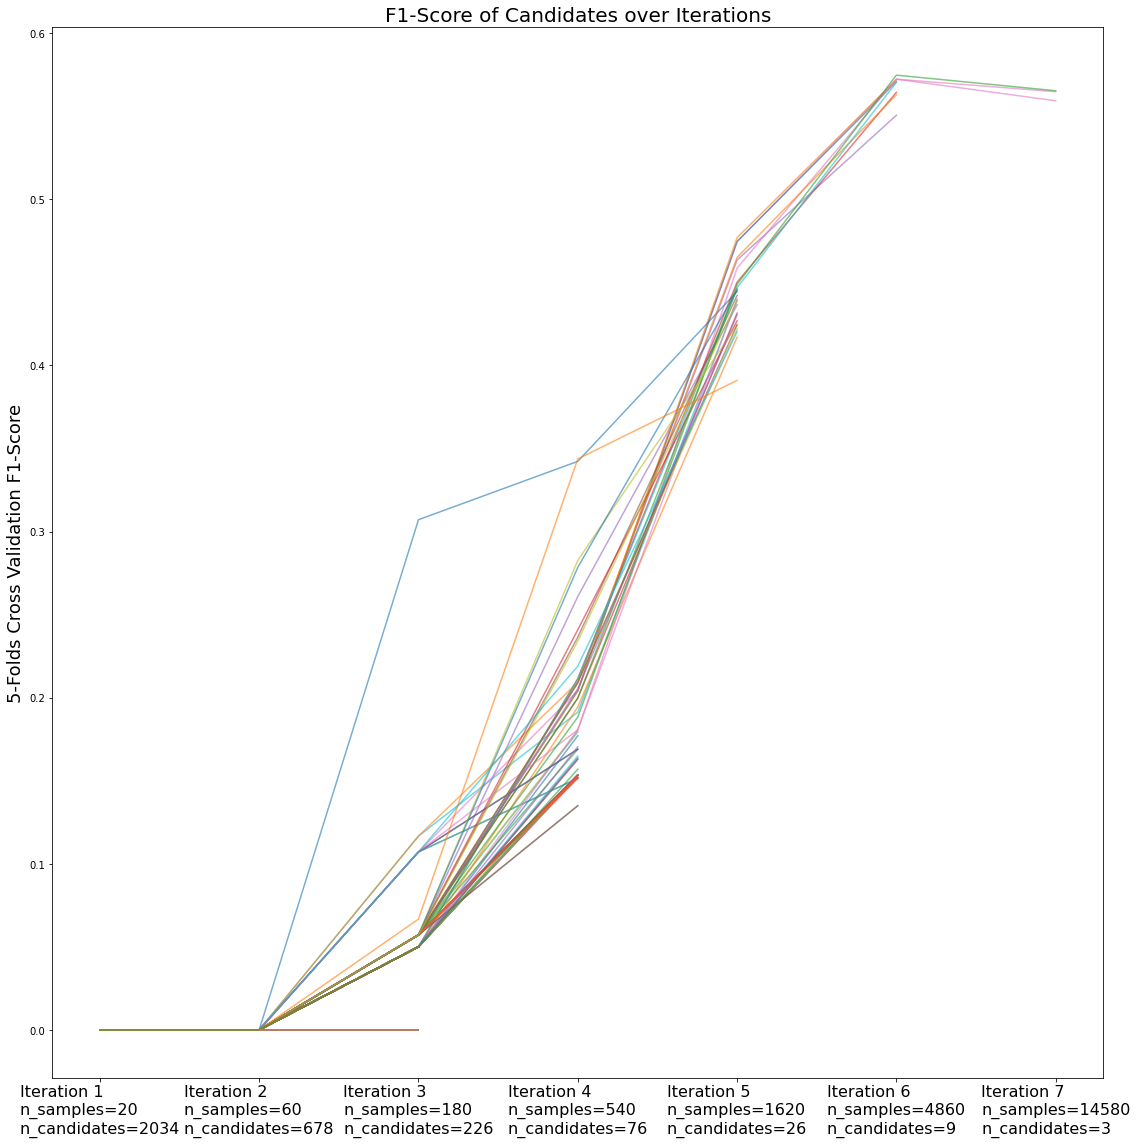

In [73]:
results = pd.DataFrame(clf.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

fig, ax = plt.subplots(figsize=(16,16))

ax = mean_scores.plot(legend=False, alpha=0.6, ax=ax)

labels = [
    f"Iteration {i+1}\nn_samples={clf.n_resources_[i]}\nn_candidates={clf.n_candidates_[i]}"
    for i in range(clf.n_iterations_)
]

ax.set_xticks(range(clf.n_iterations_))
ax.set_xticklabels(labels, rotation=0, multialignment="left",size=16)
ax.set_title("F1-Score of Candidates over Iterations",size=20)
ax.set_ylabel("5-Folds Cross Validation F1-Score", fontsize=18)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

In [74]:
results

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__class_weight,param_model__criterion,param_model__min_samples_split,param_model__n_estimators,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,params_str
0,0,20,0.065693,0.006872,0.014911,0.004732,balanced,entropy,0.008503,72,...,0.000000,237,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,"{'model__class_weight': 'balanced', 'model__cr..."
1,0,20,0.036844,0.004748,0.007425,0.001356,balanced_subsample,entropy,0.009185,26,...,0.000000,237,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,"{'model__class_weight': 'balanced_subsample', ..."
2,0,20,0.090623,0.010807,0.013557,0.002544,balanced,gini,0.006433,93,...,0.000000,237,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,"{'model__class_weight': 'balanced', 'model__cr..."
3,0,20,0.054271,0.007123,0.007954,0.001588,balanced,gini,0.007313,44,...,0.000000,237,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,"{'model__class_weight': 'balanced', 'model__cr..."
4,0,20,0.259566,0.041253,0.031525,0.003493,balanced_subsample,gini,0.007761,170,...,0.000000,237,1.000000,1.000000,1.000000,1.000000,0.000000,0.800000,0.400000,"{'model__class_weight': 'balanced_subsample', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,5,4860,0.346703,0.007141,0.019800,0.003148,balanced,entropy,0.009828,61,...,0.029331,5,0.729570,0.749568,0.748709,0.728843,0.735197,0.738378,0.009062,"{'model__class_weight': 'balanced', 'model__cr..."
3048,5,4860,0.314916,0.024769,0.016704,0.002905,balanced,entropy,0.009937,63,...,0.035162,4,0.727273,0.746552,0.748288,0.726960,0.732187,0.736252,0.009321,"{'model__class_weight': 'balanced', 'model__cr..."
3049,6,14580,1.604237,0.018108,0.060968,0.007089,balanced,gini,0.008659,140,...,0.021563,8,0.613458,0.617230,0.624326,0.618208,0.617801,0.618204,0.003496,"{'model__class_weight': 'balanced', 'model__cr..."
3050,6,14580,0.854209,0.026041,0.057337,0.003102,balanced,entropy,0.00959,55,...,0.014385,11,0.623710,0.621762,0.622047,0.611998,0.614737,0.618851,0.004608,"{'model__class_weight': 'balanced', 'model__cr..."


In [75]:
mean_scores

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005003440869919403, 'model__n_estimators': 153}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005010001061386167, 'model__n_estimators': 46}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005098820507733019, 'model__n_estimators': 157}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005147155414154571, 'model__n_estimators': 192}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005167757905181406, 'model__n_estimators': 33}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005169204034188057, 'model__n_estimators': 134}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005178594641132805, 'model__n_estimators': 52}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005180146554954901, 'model__n_estimators': 96}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005180271215491458, 'model__n_estimators': 33}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005194708911587962, 'model__n_estimators': 31}",...,"{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009869072120690391, 'model__n_estimators': 66}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009872077553378301, 'model__n_estimators': 48}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009884054997182768, 'model__n_estimators': 182}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009897704203271946, 'model__n_estimators': 138}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009907707667072874, 'model__n_estimators': 11}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009929886744642541, 'model__n_estimators': 106}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009950637820544967, 'model__n_estimators': 148}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009969573118841207, 'model__n_estimators': 33}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009977335280360449, 'model__n_estimators': 35}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009980091168542479, 'model__n_estimators': 81}"
iter,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Hyper Band

In [76]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from scipy.stats import randint,truncnorm
from hyperband import HyperbandSearchCV

In [77]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [78]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [79]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [80]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [81]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [82]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [83]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [84]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [85]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [86]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [87]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Define the hyperparameter space

In [88]:
hyperparameter_space = {
"model__criterion": ["gini", "entropy"],
"model__class_weight": ["balanced","balanced_subsample"],
"model__min_samples_split": truncnorm(a=0,b=0.5,loc=0.005, scale=0.01),
} 

Perform Hyper Band

In [89]:
# Initiate the HB Class
clf = HyperbandSearchCV(pipe, hyperparameter_space,
                        resource_param='model__n_estimators',
                        eta=3,min_iter=1,max_iter=100,
                        random_state = 0,
                        scoring = 'f1', cv=5, 
                        n_jobs=-1, refit = True,
                        verbose=2)

# Run the HB CV
clf.fit(X_train_full, y_train)

Starting bracket 1 (out of 5) of hyperband
Starting successive halving iteration 1 out of 5. Fitting 81 configurations, with resource_param model__n_estimators set to 1, and keeping the best 27 configurations.
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Starting successive halving iteration 2 out of 5. Fitting 27 configurations, with resource_param model__n_estimators set to 3, and keeping the best 9 configurations.
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Starting successive halving iteration 3 out of 5. Fitting 9 configurations, with resource_param model__n_estimators set to 11, and keeping the best 3 configurations.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Starting successive halving iteration 4 out of 5. Fitting 3 configurations, with resource_param model__n_estimators set to 33, and keeping the best 1 configurations.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Starting successive halving iteration 5 out of 5

HyperbandSearchCV(cv=5,
                  estimator=Pipeline(steps=[('preprocessor',
                                             ColumnTransformer(transformers=[('num',
                                                                              StandardScaler(),
                                                                              ['age',
                                                                               'balance',
                                                                               'day',
                                                                               'duration',
                                                                               'campaign',
                                                                               'pdays',
                                                                               'previous']),
                                                                             ('cat',
                        

In [90]:
clf.best_params_,clf.best_score_

({'model__class_weight': 'balanced',
  'model__criterion': 'entropy',
  'model__min_samples_split': 0.0055643644642829684,
  'model__n_estimators': 33},
 0.5601380695244504)

In [91]:
clf.score(X_test_full,y_test)

0.5695284159613059

In [92]:
def del_key(dict_,key):
    del dict_[key]
    return dict_

In [93]:
#delete model__n_estimators from params
results = pd.DataFrame(clf.cv_results_)
results['params'] = results['params'].apply(lambda x: del_key(x,'model__n_estimators'))

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005022534793470857}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005096502682891996}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005577173905818139}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.006436456848526463}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.006754499672946753}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007113046265838072}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007429677252603323}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.0075661893831361834}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007766131793967021}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007998561260633821}",...,"{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008188066613355166}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008259899856330119}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008276239041798021}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008332918182480022}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008387309876201078}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008508505640352257}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.008805642344802703}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.00910868297031522}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009294814415967953}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009619051711474445}"
SH_iter,,,,,,,,,,,,,,,,,,,,,
0,0.475406,0.470009,0.472849,0.476851,0.465611,0.465694,0.459603,0.456367,0.462497,0.467737,...,0.473879,0.472255,0.47259,0.469706,0.468681,0.459842,0.476738,0.472393,0.467226,0.462654
1,0.525144,NaN,NaN,0.526648,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.522398,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


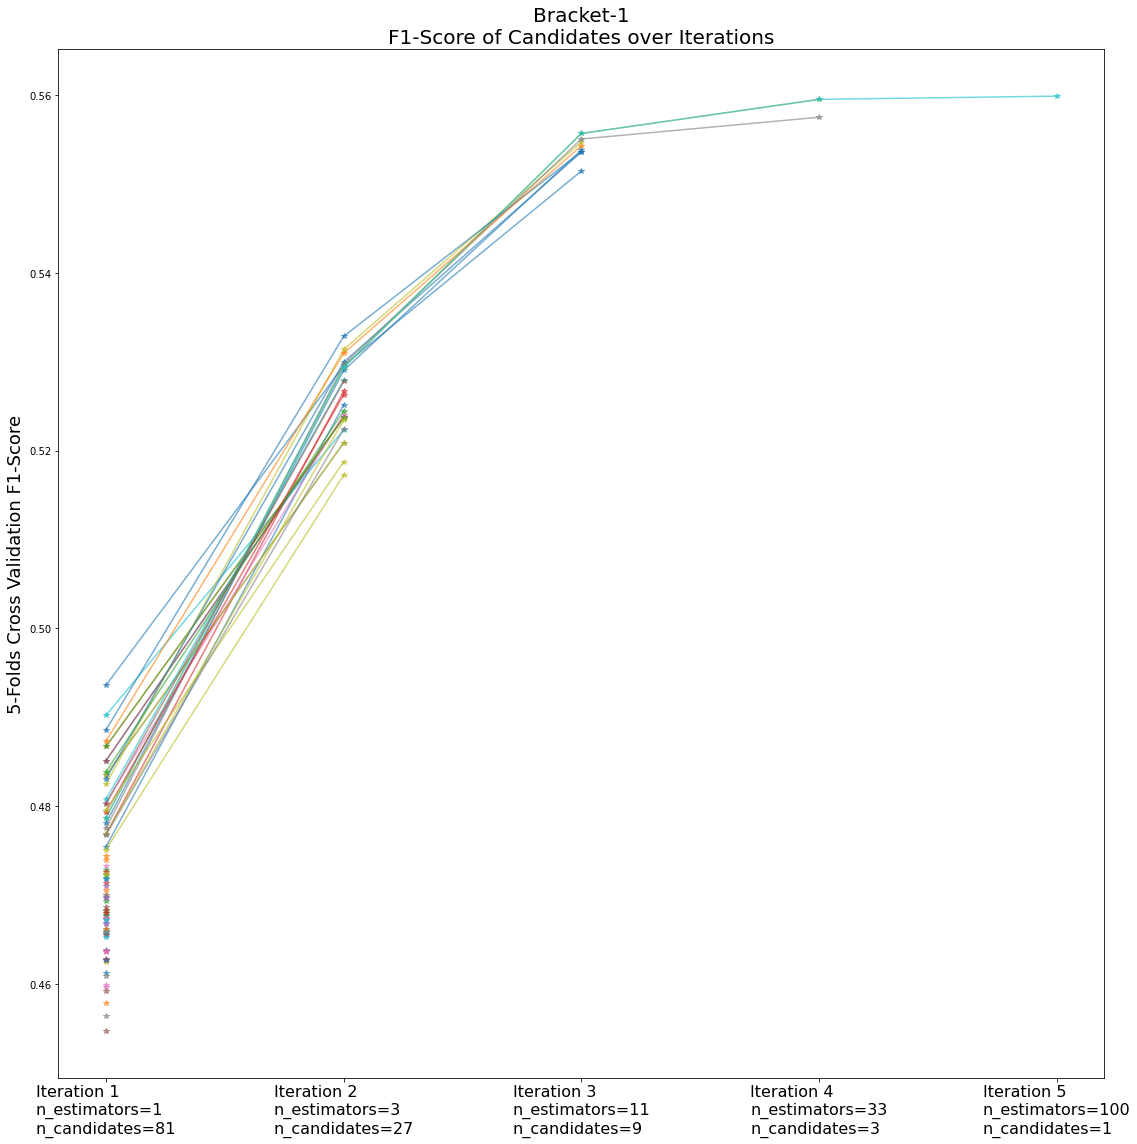

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005088891933280073}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005152808999026509}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.008028286725485494}","{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.008406690731277089}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.0052608112748995855}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.006144199376846187}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.008723961597705651}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.00928563909211048}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005529966114173286}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.005824627744984229}",...,"{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.0057749399858041065}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.006008801525696762}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.006042830369699549}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.0060767480477817385}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.006267133246803643}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.00710021301875423}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.007194902540337529}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.007870046392599795}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009445538366843986}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.00961256566140634}"
SH_iter,,,,,,,,,,,,,,,,,,,,,
0,0.529942,0.529465,0.522498,0.51859,0.529064,0.529613,0.516202,0.516467,NaN,0.53064,...,NaN,0.528191,0.526791,0.524776,0.526279,0.518743,0.52285,0.520809,0.514134,0.515175
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.554695,NaN,...,0.554291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


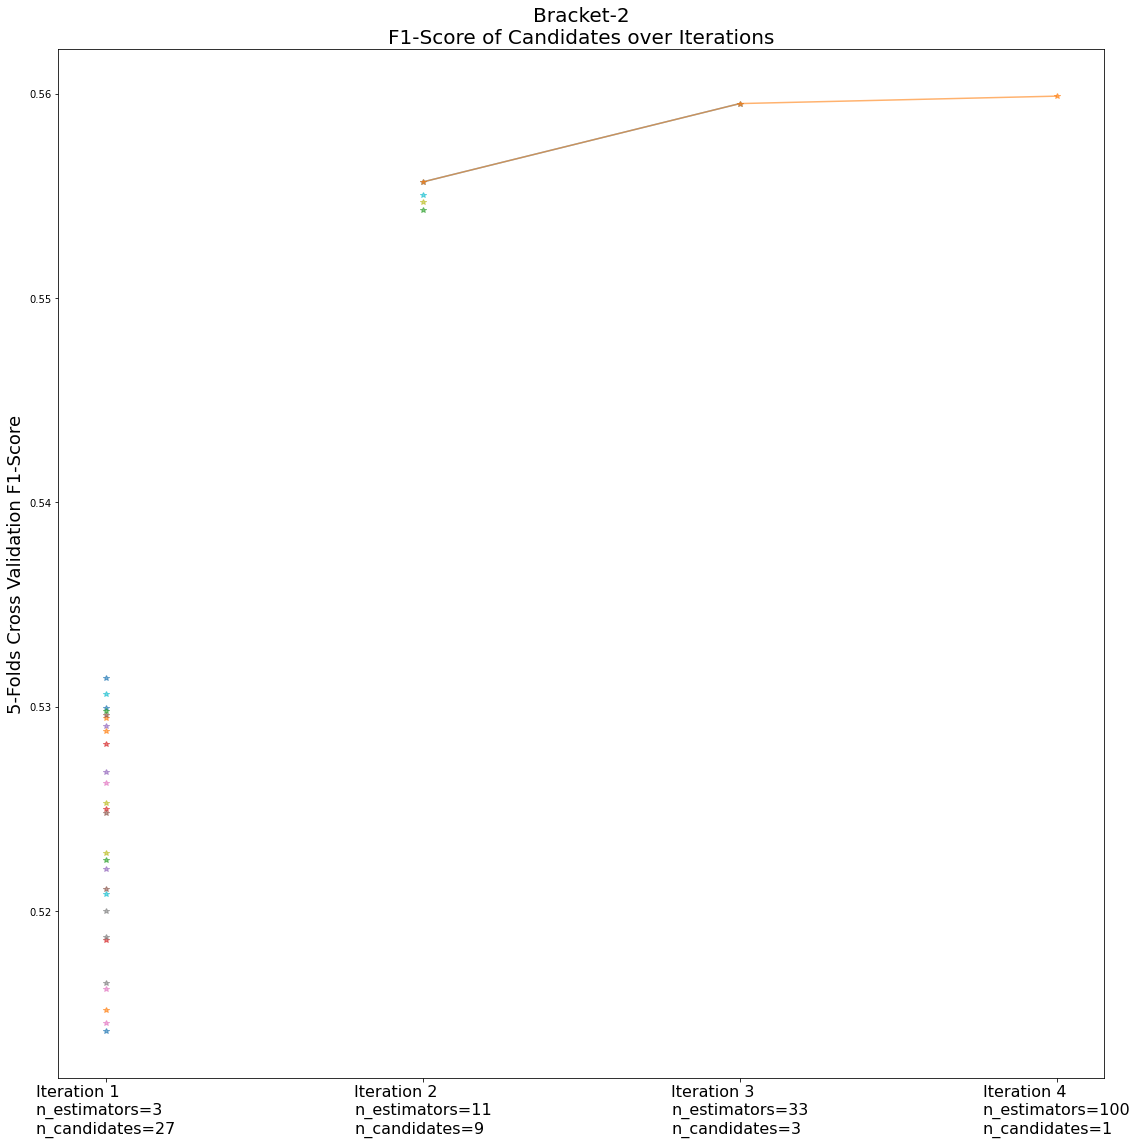

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.006036126613642236}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.005123164969684289}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.006025532759934307}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.006850853169371979}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.008928801841646686}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.00910047866684437}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.005466182311285859}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.00858275572428024}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009318639251244093}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.009744874735171025}"
SH_iter,,,,,,,,,,
0,0.554391,0.556474,0.553462,0.550811,0.545948,0.542135,NaN,0.542801,0.541499,0.539719
1,NaN,NaN,NaN,NaN,NaN,NaN,0.559508,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.559872,NaN,NaN,NaN


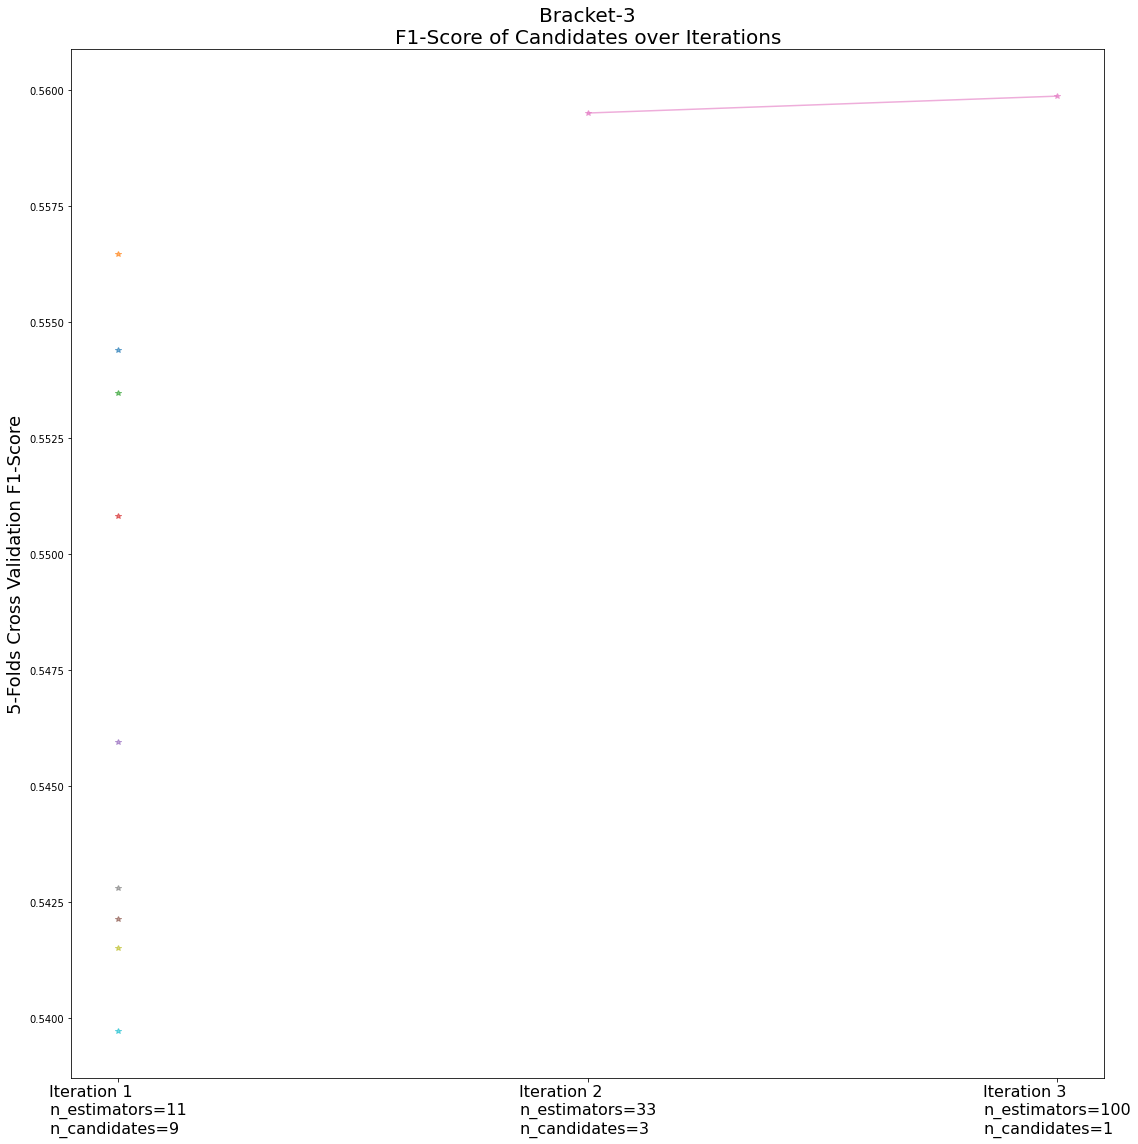

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.0055643644642829684}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.005634253134532613}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.006912383373655413}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.0070524930468105484}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007243494302458287}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.007854418490576887}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.005466182311285859}"
SH_iter,,,,,,,
0,0.560138,0.557068,0.55205,0.552663,0.553511,0.549344,NaN
1,0.558619,NaN,NaN,NaN,NaN,NaN,0.559872


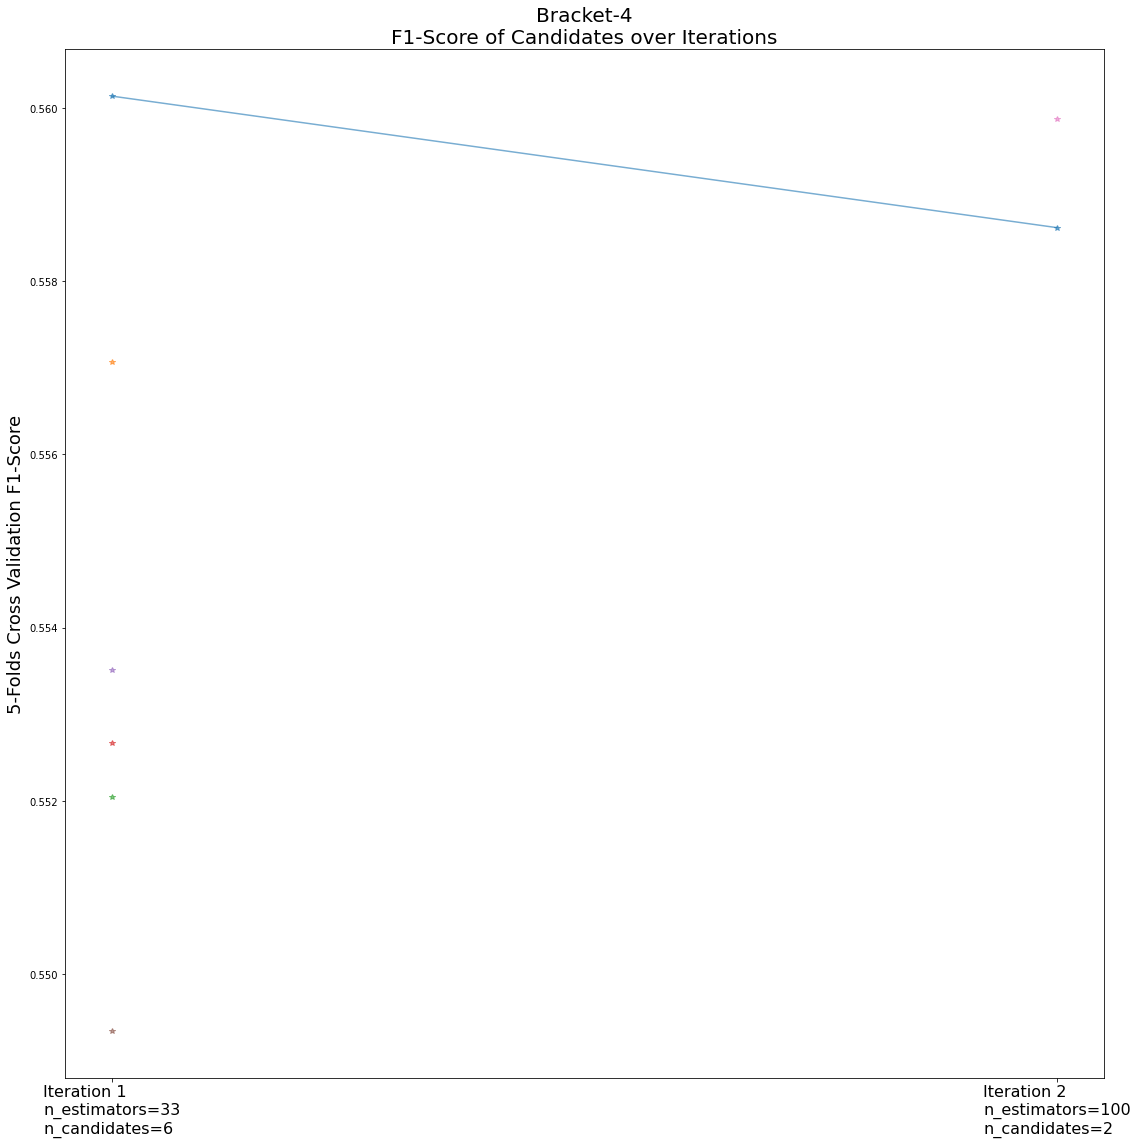

params_str,"{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__min_samples_split': 0.00867403526682592}","{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__min_samples_split': 0.005400472325183361}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__min_samples_split': 0.009678593564320832}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.005880743499499384}","{'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__min_samples_split': 0.007364144473535205}"
SH_iter,,,,,
0,0.550262,0.557358,0.549462,0.556488,0.552869


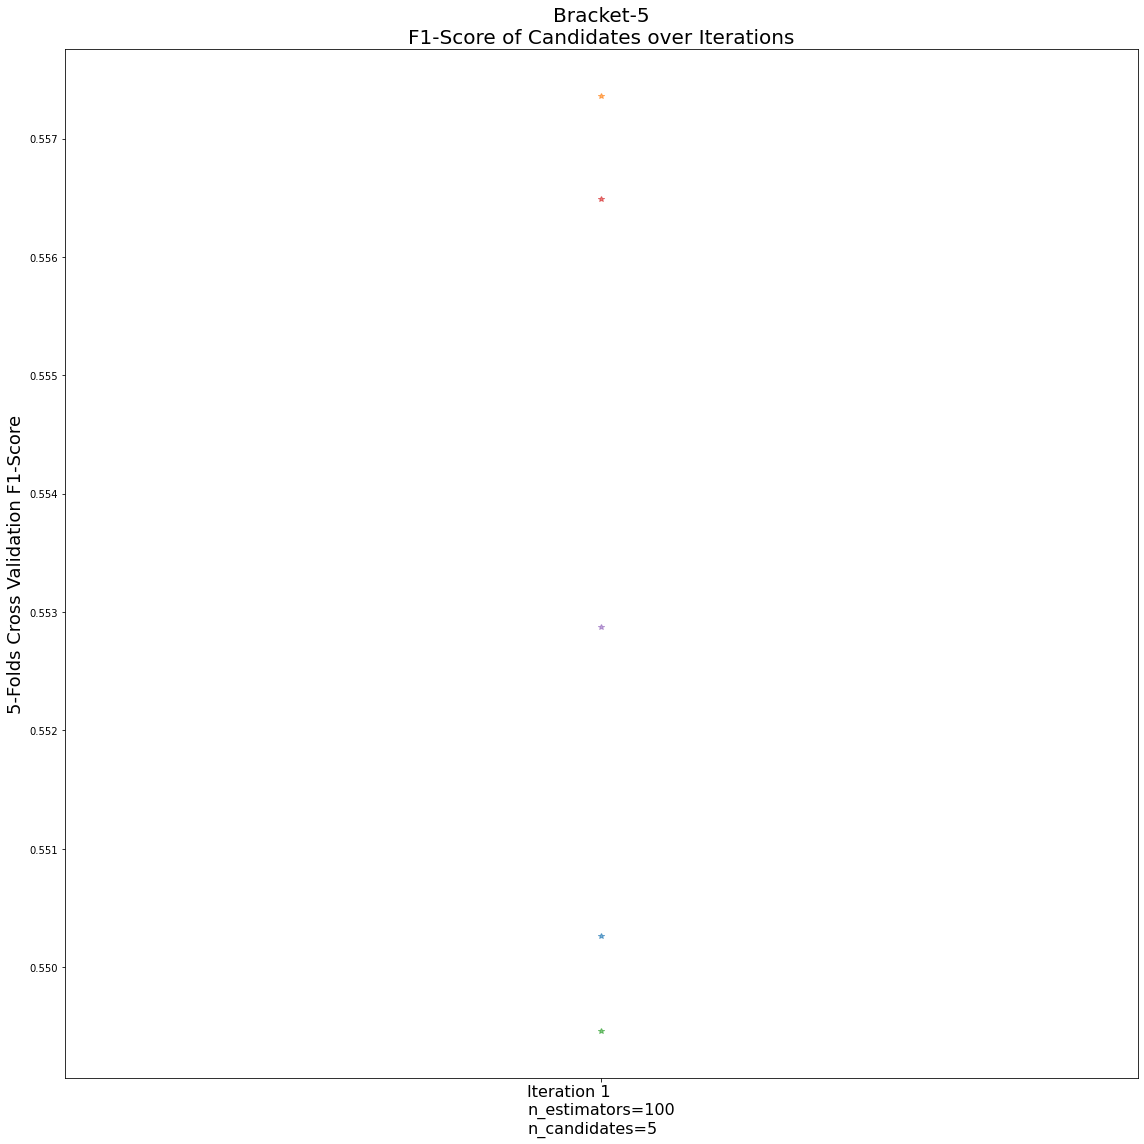

In [94]:
import warnings
warnings.filterwarnings('ignore')

for bracket_i, bracket in enumerate(results['hyperband_bracket'].unique()):
    results_SH = results[results['hyperband_bracket']==bracket]
    results_SH["params_str"] = results_SH.params.apply(str)
    results_SH.drop_duplicates(subset=("params_str", "SH_iter"), inplace=True)
    mean_scores = results_SH.pivot(
        index="SH_iter", columns="params_str", values="mean_test_score"
    )
    
    display(mean_scores)

    fig, ax = plt.subplots(figsize=(16,16))

    ax = mean_scores.plot(legend=False, alpha=0.6, marker="*",ax=ax)

    labels = [
        f"Iteration {i+1}\nn_estimators={clf.n_resources_[bracket_i][i]}\nn_candidates={int(clf.n_candidates_[bracket_i][i])}"
        for i in range(clf.n_trials_[bracket_i])
    ]

    ax.set_xticks(range(clf.n_trials_[bracket_i]))
    ax.set_xticklabels(labels, rotation=0, multialignment="left",size=16)
    ax.set_title(f"Bracket-{bracket_i+1}\nF1-Score of Candidates over Iterations",size=20)
    ax.set_ylabel("5-Folds Cross Validation F1-Score", fontsize=18)
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()

# Bayesian Optimization

Custom `Real` Hyperparameter Space wrapper.

`truncnorm` distribution is added here.

In [95]:
from skopt.space import *
from scipy.stats import truncnorm

In [96]:
class Real(Dimension):
    """Search space dimension that can take on any real value.
    Parameters
    ----------
    low : float
        Lower bound (inclusive).
    high : float
        Upper bound (inclusive).
    prior : "uniform",  "log-uniform", or "truncnorm", default="uniform"
        Distribution to use when sampling random points for this dimension.
        - If `"uniform"`, points are sampled uniformly between the lower
          and upper bounds.
        - If `"log-uniform"`, points are sampled uniformly between
          `log(lower, base)` and `log(upper, base)` where log
          has base `base`.
        - If "truncnorm", points are sample from the truncated normal
          distribution between the lower and upper bounds, with mean and std
          equal to loc and scale, respectively. The loc and scale needs to be
          given through **kwargs.
    base : int
        The logarithmic base to use for a log-uniform prior.
        - Default 10, otherwise commonly 2.
    transform : "identity", "normalize", optional
        The following transformations are supported.
        - "identity", (default) the transformed space is the same as the
          original space.
        - "normalize", the transformed space is scaled to be between
          0 and 1.
    name : str or None
        Name associated with the dimension, e.g., "learning rate".
    dtype : str or dtype, default=np.float
        float type which will be used in inverse_transform,
        can be float.
    """
    def __init__(self, low, high, prior="uniform", base=10, transform=None,
                 name=None, dtype=np.float, **kwargs):
        if high <= low:
            raise ValueError("the lower bound {} has to be less than the"
                             " upper bound {}".format(low, high))
        self.low = low
        self.high = high
        self.prior = prior
        self.base = base
        self.log_base = np.log10(base)
        self.name = name
        self.dtype = dtype
        self._rvs = None
        self.transformer = None
        self.transform_ = transform
        self.kwargs = kwargs
        if isinstance(self.dtype, str) and self.dtype\
                not in ['float', 'float16', 'float32', 'float64']:
            raise ValueError("dtype must be 'float', 'float16', 'float32'"
                             "or 'float64'"
                             " got {}".format(self.dtype))
        elif isinstance(self.dtype, type) and self.dtype\
                not in [float, np.float, np.float16, np.float32, np.float64]:
            raise ValueError("dtype must be float, np.float"
                             " got {}".format(self.dtype))

        if transform is None:
            transform = "identity"
        self.set_transformer(transform)

    def set_transformer(self, transform="identity"):
        """Define rvs and transformer spaces.
        Parameters
        ----------
        transform : str
           Can be 'normalize' or 'identity'
        """
        self.transform_ = transform

        if self.transform_ not in ["normalize", "identity"]:
            raise ValueError("transform should be 'normalize' or 'identity'"
                             " got {}".format(self.transform_))

        # XXX: The _rvs is for sampling in the transformed space.
        # The rvs on Dimension calls inverse_transform on the points sampled
        # using _rvs
        if self.transform_ == "normalize":
            # set upper bound to next float after 1. to make the numbers
            # inclusive of upper edge
            self._rvs = _uniform_inclusive(0., 1.)
            if self.prior == "uniform":
                self.transformer = Pipeline(
                    [Identity(), Normalize(self.low, self.high)])
            elif self.prior == "log-uniform":
                self.transformer = Pipeline(
                    [LogN(self.base),
                     Normalize(np.log10(self.low) / self.log_base,
                               np.log10(self.high) / self.log_base)]
                )
            else: #self.prior == "truncnorm"
                self.transformer = Pipeline(
                    [Identity(), Normalize(self.low+1e-6, self.high)])
                
        else:
            if self.prior == "uniform":
                self._rvs = _uniform_inclusive(self.low, self.high - self.low)
                self.transformer = Identity()
            elif self.prior == "log-uniform":
                self._rvs = _uniform_inclusive(
                    np.log10(self.low) / self.log_base,
                    np.log10(self.high) / self.log_base -
                    np.log10(self.low) / self.log_base)
                self.transformer = LogN(self.base)
            else: #self.prior == "truncnorm"
                self._rvs = truncnorm(a=self.low,b=self.high,
                                      loc=self.kwargs.get("loc",(self.low + self.high)/2), 
                                      scale=self.kwargs.get("scale",(self.low + self.high)))
                self.transformer = Identity()

    def __eq__(self, other):
        return (type(self) is type(other) and
                np.allclose([self.low], [other.low]) and
                np.allclose([self.high], [other.high]) and
                self.prior == other.prior and
                self.transform_ == other.transform_)

    def __repr__(self):
        return "Real(low={}, high={}, prior='{}', transform='{}')".format(
            self.low, self.high, self.prior, self.transform_)

    def inverse_transform(self, Xt):
        """Inverse transform samples from the warped space back into the
           original space.
        """

        inv_transform = super(Real, self).inverse_transform(Xt)
        if isinstance(inv_transform, list):
            inv_transform = np.array(inv_transform)
        inv_transform = np.clip(inv_transform,
                                self.low, self.high).astype(self.dtype)
        if self.dtype == float or self.dtype == 'float':
            # necessary, otherwise the type is converted to a numpy type
            return getattr(inv_transform, "tolist", lambda: value)()
        else:
            return inv_transform

    @property
    def bounds(self):
        return (self.low, self.high)

    @property
    def is_constant(self):
        return self.low == self.high

    def __contains__(self, point):
        if isinstance(point, list):
            point = np.array(point)
        return self.low <= point <= self.high

    @property
    def transformed_bounds(self):
        if self.transform_ == "normalize":
            return 0.0, 1.0
        else:
            if self.prior in ["uniform","truncnorm"]:
                return self.low, self.high
            else:
                return np.log10(self.low), np.log10(self.high)

    def distance(self, a, b):
        """Compute distance between point `a` and `b`.
        Parameters
        ----------
        a : float
            First point.
        b : float
            Second point.
        """
        if not (a in self and b in self):
            raise RuntimeError("Can only compute distance for values within "
                               "the space, not %s and %s." % (a, b))
        return abs(a - b)
    

def _uniform_inclusive(loc=0.0, scale=1.0):
    # like scipy.stats.distributions but inclusive of `high`
    # XXX scale + 1. might not actually be a float after scale if
    # XXX scale is very large.
    return uniform(loc=loc, scale=np.nextafter(scale, scale + 1.))

In [97]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline as Sklearn_Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from skopt import BayesSearchCV

Load Data

In [98]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [99]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [100]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [101]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [102]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [103]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [104]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [105]:
pipe = Sklearn_Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [106]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [107]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Calculate F1-Score on Test Data without Hyperparameter Tuning

In [108]:
# Fit the pipeline on train data 
pipe.fit(X_train_full,y_train)

# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.5164319248826291


Define the hyperparameter space

In [109]:
hyperparameter_space = {
"model__n_estimators": Integer(low=5, high=200), 
"model__criterion": Categorical(["gini", "entropy"]),
"model__class_weight": Categorical(["balanced","balanced_subsample"]),
"model__min_samples_split": Real(low=0,high=0.5,prior="truncnorm",
                                 **{"loc":0.005,"scale":0.01})
} 

## BOGP

Perform Bayesian Optimization Gaussian Process

In [110]:
# Initiate the BOGP Class
clf = BayesSearchCV(pipe, hyperparameter_space,
                    n_iter=50,
                    optimizer_kwargs={"base_estimator":"GP",
                                      "n_initial_points":10,
                                      "initial_point_generator":"random",
                                      "acq_func":"EI",
                                      "acq_optimizer":"auto",
                                      "n_jobs":-1,
                                      "random_state":0,
                                      "acq_func_kwargs": {"xi":0.01}
                                     },
                    random_state = 0,
                    scoring = 'f1', cv=5, 
                    n_jobs=-1, refit = True,
                    verbose=2)

# Run the BOGP CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'balance',
                                                                           'day',
                                                                           'duration',
                                                                           'campaign',
                                                                           'pdays',
                                                                           'previous']),
                                                                         ('cat',
                                                                        

In [111]:
clf.best_params_,clf.best_score_

(OrderedDict([('model__class_weight', 'balanced'),
              ('model__criterion', 'entropy'),
              ('model__min_samples_split', 0.02363008892366518),
              ('model__n_estimators', 94)]),
 0.529918160187435)

In [112]:
clf.score(X_test_full,y_test)

0.5389830508474576

## BORF

Perform Bayesian Optimization Random Forest

In [113]:
# Initiate the BORF Class
clf = BayesSearchCV(pipe, hyperparameter_space,
                    n_iter=50,
                    optimizer_kwargs={"base_estimator":"RF",
                                      "n_initial_points":10,
                                      "initial_point_generator":"random",
                                      "acq_func":"LCB",
                                      "acq_optimizer":"auto",
                                      "n_jobs":-1,
                                      "random_state":0,
                                      "acq_func_kwargs": {"kappa":1.96}
                                     },
                    random_state = 0,
                    scoring = 'f1', cv=5, 
                    n_jobs=-1, refit = True,
                    verbose=2)

# Run the BORF CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'balance',
                                                                           'day',
                                                                           'duration',
                                                                           'campaign',
                                                                           'pdays',
                                                                           'previous']),
                                                                         ('cat',
                                                                        

In [114]:
clf.best_params_,clf.best_score_

(OrderedDict([('model__class_weight', 'balanced_subsample'),
              ('model__criterion', 'gini'),
              ('model__min_samples_split', 0.00043534042560206855),
              ('model__n_estimators', 85)]),
 0.6159818376646041)

In [115]:
clf.score(X_test_full,y_test)

0.6171875

## BOGBRT

Perform Bayesian Optimization Gradient Boosted Trees

In [116]:
# Initiate the BOGBRT Class
clf = BayesSearchCV(pipe, hyperparameter_space,
                    n_iter=50,
                    optimizer_kwargs={"base_estimator":"GBRT",
                                      "n_initial_points":10,
                                      "initial_point_generator":"random",
                                      "acq_func":"LCB",
                                      "acq_optimizer":"auto",
                                      "n_jobs":-1,
                                      "random_state":0,
                                      "acq_func_kwargs": {"kappa":1.96}
                                     },
                    random_state = 0,
                    scoring = 'f1', cv=5, 
                    n_jobs=-1, refit = True,
                    verbose=2)

# Run the BOGBRT CV
clf.fit(X_train_full, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'balance',
                                                                           'day',
                                                                           'duration',
                                                                           'campaign',
                                                                           'pdays',
                                                                           'previous']),
                                                                         ('cat',
                                                                        

In [117]:
clf.best_params_,clf.best_score_

(OrderedDict([('model__class_weight', 'balanced_subsample'),
              ('model__criterion', 'gini'),
              ('model__min_samples_split', 0.0005745541104096049),
              ('model__n_estimators', 143)]),
 0.6175018084891714)

In [118]:
clf.score(X_test_full,y_test)

0.6109467455621302